In [1]:

from glob import glob
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import scipy.signal as signal
from scipy.interpolate import interp1d
import os

In [2]:
reforecast = xr.open_dataset('data/S2S/reforecasts/2020-01-06/2000-01-06_SSH.nc')
reforecast = reforecast.sortby('lat').sortby('lon').sel({'lon':slice(220,290),'lat':slice(-40,40)})
reforecast = reforecast.assign_coords({'i':('lat',range(len(reforecast.lat))),'j':('lon',range(len(reforecast.lon)))})

In [3]:
lon,lat = np.meshgrid(reforecast.lon,reforecast.lat)

In [19]:
tropicalmask = reforecast.dslm[0,0,:,:].where(reforecast.lat>=-2).where(reforecast.lat<=2)
tropicalmask = xr.where(~np.isnan(tropicalmask),1,0).to_dataset(name='tropicalmask')

watermask = reforecast.dslm[0,0,:,:].fillna(-9999)
watermask = xr.where(watermask==-9999,0,1)
watermask = watermask.differentiate('lon')!=0
watermask = watermask.where(watermask).ffill('lon')#.bfill('lon',limit=1)
x = xr.concat([watermask[i,:].dropna('lon').isel(lon=0).j for i in range(len(watermask.lat))],'lat')
watermask = xr.where(watermask==9999,1,0)
watermask[:,x[:]] = 1
watermask[23,[65,67]]=1
watermask[33,58]=1
watermask[37,58]=1
watermask[47,[58,59,60]]=1
watermask[48,56]=1
watermask[53,[48,49,50]]=1
watermask[55,[42,43,44,45]]=1
watermask[55,[42,43,44,45]]=1
watermask[56,[39,40]]=1
watermask[58,[35,36,37]]=1
watermask[62,[29,30,31,32]]=1
watermask[64,27]=1
watermask[74,19]=1
watermask[37,59]=1
watermask[33,59]=1
watermask[23,[66,68]]=1
watermask[47,[57,61]]=1
watermask[48,[57]]=1
watermask[53,[51]]=1
watermask[55,[46]]=1
watermask[56,[41]]=1
watermask[62,[33]]=1
watermask[64,[28]]=1
watermask[74,[20]]=1


watermask = watermask.where(abs(reforecast.lat)>2).fillna(0)


coastmask_south = watermask.sel(lat=slice(-90,-2)).reindex({'lat':tropicalmask.lat,'lon':tropicalmask.lon}).fillna(0).to_dataset(name='coastmask_south')
coastmask_north = watermask.sel(lat=slice(2,90)).reindex({'lat':tropicalmask.lat,'lon':tropicalmask.lon}).fillna(0).to_dataset(name='coastmask_north')

masks = xr.merge([tropicalmask,coastmask_south,coastmask_north])


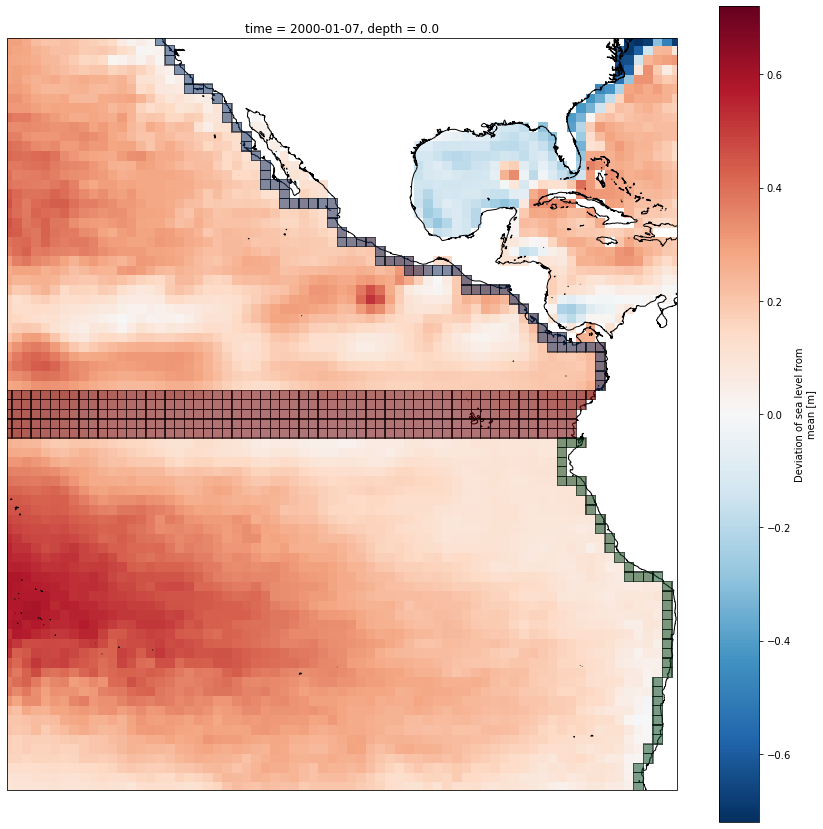

In [5]:

fig, ax = plt.subplots(1,1, subplot_kw={'projection':ccrs.PlateCarree()}, figsize=(15,15))
ax.set_extent([-140,-70,-34,34])
ax.coastlines('10m')

# tropicalmask.where(tropicalmask).plot(ax=ax, add_colorbar=False, cmap='Blues')
# coastmask_north.where(coastmask_north).plot(ax=ax, add_colorbar=False, cmap='Reds')
# coastmask_south.where(coastmask_south).plot(ax=ax, add_colorbar=False, cmap='Greens')

ax.pcolor(tropicalmask.lon, tropicalmask.lat, tropicalmask.where(tropicalmask), cmap='Reds_r', alpha=0.5, ec='k', zorder=2)
ax.pcolor(coastmask_north.lon, coastmask_north.lat,coastmask_north.where(coastmask_north), cmap='Blues_r', alpha=0.5, ec='k', zorder=2)
ax.pcolor(coastmask_south.lon, coastmask_south.lat,coastmask_south.where(coastmask_south), cmap='Greens_r', alpha=0.5, ec='k', zorder=2)

reforecast.dslm[0].plot(ax=ax)

In [26]:
masks.drop(['j','i','depth','time']).to_netcdf('data/MASKS.nc')